# Visualisation of MouseReMoCo data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fnameDataCSV = "../data.csv"
fnameMarkerCSV = "../marker.csv"
# use of default XDF file creation path from LabRecorder
fnameXDF = "/Users/denismottet/Documents/CurrentStudy/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"

## Read the data from the CSV file

In [2]:
# read the data from the csv file
data_csv = np.genfromtxt(fnameDataCSV, delimiter=',', skip_header=4)

t0 = data_csv[0,0]

def timeInSecFromT0(time):
    return (time - t0) / 1000

def removeZeros(data):
    # find rows full of zeros
    rows = np.where(~data.any(axis=1))[0]
    # replace rows full of zeros with NaN
    data[rows,:] = np.nan
    return data

# remove rows full of zeros
data_csv = removeZeros(data_csv)
data_csv[:,0] = timeInSecFromT0(data_csv[:,0])

print(data_csv.shape)

(1719, 4)


## Read the markers from the CSV file

In [3]:

marker_csv = np.genfromtxt(fnameMarkerCSV, delimiter=',', skip_header=4, dtype=str, invalid_raise  = False)
    
def find_substring(label, strings):
    """Find all indices of strings that contain a given substring."""
    iFound = np.array([], dtype=int)
    for i in range(0, strings.size):
        if label in strings[i]:
            iFound = np.append(iFound, i)
    return iFound

def time_of_label_in_markers(label, markers):
    """Find the time of markers that contain a given label."""
    strings = markers[:,2]
    time = marker_csv[:,1].astype(float)
    time = timeInSecFromT0(time)
    iFound = find_substring(label, strings)
    time = time[iFound]
    return time

# find time of marker that contains "DoPause" and "DoRecord"
timeDoPause = time_of_label_in_markers("DoPause", marker_csv) 
timeDoRecord = time_of_label_in_markers("DoRecord", marker_csv) 


/var/folders/c6/hf96t_d56jggycpvmb1mz3tr0000gn/T/ipykernel_36508/1791853193.py:1: ConversionWarning: Some errors were detected !
    Line #15 (got 10 columns instead of 3)
    Line #16 (got 10 columns instead of 3)
    Line #17 (got 10 columns instead of 3)
    Line #18 (got 10 columns instead of 3)
    Line #19 (got 10 columns instead of 3)
    Line #20 (got 10 columns instead of 3)
    Line #21 (got 10 columns instead of 3)
    Line #22 (got 10 columns instead of 3)
    Line #23 (got 10 columns instead of 3)
  marker_csv = np.genfromtxt(fnameMarkerCSV, delimiter=',', skip_header=4, dtype=str, invalid_raise  = False)


# Read the data from the XDF file 

In [4]:
import pyxdf

data_xdf, header = pyxdf.load_xdf(fnameXDF)

for stream in data_xdf:
    print("------------------")
    ts = stream['time_series']
    print(stream['info']['name'][0] + ", " +stream['info']['type'][0] + ", " + stream['info']['channel_format'][0] + ", " + stream['info']['channel_count'][0] + " chanel(s)")
    if isinstance(ts, list):
        print("\t" + str(len(ts)) + " items")
        for timestamp, marker_csv in zip(stream['time_stamps'], ts):
            print(f'\t{timestamp:.2f}s : "{marker_csv[0]}"')
    elif isinstance(ts, np.ndarray):
        print("\t " + str(ts.shape) + " samples")
        print(ts)
    
print("------------------")



------------------
MouseMarkers, Markers, string, 1 chanel(s)
	12 items
	3031302.78s : "KeyTyped=32 ASCI=  DoCycleChange"
	3031302.78s : "DoCycleChange:DoStartCycleTimedSequence"
	3031302.78s : "DoCycleChange:DoRecord RecordDone=0 PauseDone=0 ToDo=6"
	3031305.65s : "KeyTyped=32 ASCI=  DoCycleChange"
	3031305.65s : "DoCycleChange:DoPause RecordDone=1 PauseDone=0 ToDo=6"
	3031309.13s : "KeyTyped=32 ASCI=  DoCycleChange"
	3031309.13s : "DoCycleChange:DoRecord RecordDone=1 PauseDone=1 ToDo=6"
	3031312.02s : "KeyTyped=32 ASCI=  DoCycleChange"
	3031312.02s : "DoCycleChange:DoPause RecordDone=2 PauseDone=1 ToDo=6"
	3031317.16s : "KeyTyped=113 ASCI=q WINDOW_CLOSING"
	3031317.17s : "
    Var , nLaps ,      Re ,      Te ,   error ,  MT/lap , IDe/lap ,      Be ,     IPe ,
   unit ,   lap ,   pixel ,   pixel ,       % ,   s/lap , bit/lap ,  double ,   bit/s ,
 Theory ,  1.00 ,  286.50 ,   47.00 ,    3.88 ,         ,         ,    1.00 ,         ,
 Rec001 ,  0.03 ,  294.38 ,  226.02 , -149.94 ,   88

# Plot the data and the markers from the XDF file

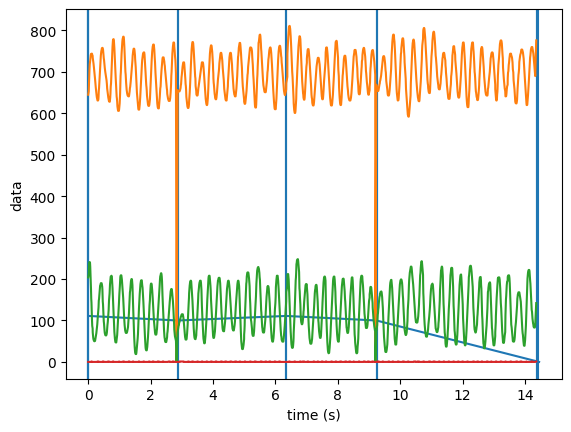

In [5]:
# plot the data and the markers in the same figure
for stream in data_xdf:
    yy = stream['time_series']
    time = stream['time_stamps'] - stream['time_stamps'][0]

    if isinstance(yy, list):
        # list of strings, draw one vertical line for each marker
        for timestamp, marker_csv in zip(time, yy):
            plt.axvline(x=timestamp)
    elif isinstance(yy, np.ndarray):
        # numeric data, draw as lines
        plt.plot(time, yy)
    else:
        raise RuntimeError('Unknown stream format')

# add labels and legend
plt.ylabel('data')
plt.xlabel('time (s)')
plt.show()

## Plot the data and the markers from CSV files

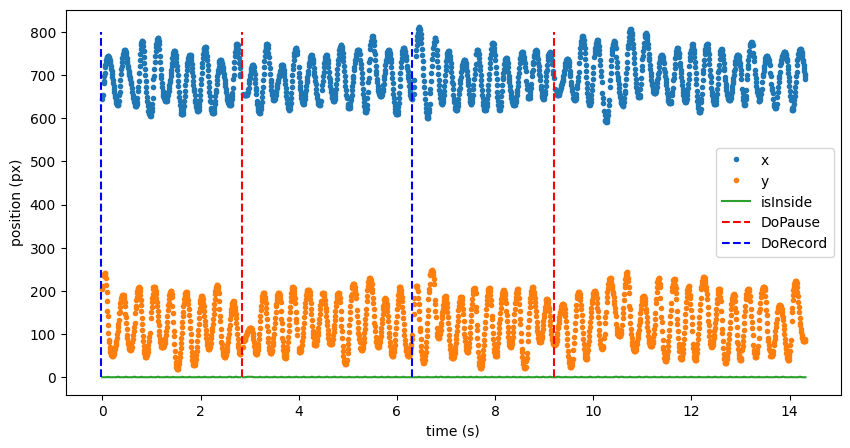

Pause 0: 2.836
Pause 1: 9.205


In [6]:
# plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


t = data_csv[:,0]
x = data_csv[:,1]
y = data_csv[:,2]
isInside = data_csv[:,3]

ax.plot(t, x, ".", label='x')
ax.plot(t, y, ".", label='y')
ax.plot(t, isInside, label='isInside')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (px)')

def plotMarker(ax, time2plot, label, color='red'):
    """Plot a marker at the given time """
    x2plot = np.array([])
    y2plot = np.array([])
    for i in range(len(time2plot)):
        x2plot = np.append(x2plot, [time2plot[i] , time2plot[i], np.nan] )
        y2plot = np.append(y2plot, [0, 800, np.nan])
        
    ax.plot(x2plot, y2plot, label=label, marker='none', color=color, linestyle='--')

plotMarker(ax, timeDoPause, 'DoPause', color='red')
plotMarker(ax, timeDoRecord, 'DoRecord', color='blue')

ax.legend()

plt.show()


# console output: all markers and their time
for i in range(len(timeDoPause)):
    print(f"Pause {i}: {timeDoPause[i]}")


# Comparison of the data from the CSV and the XDF file

CSV:(1719, 4)
XDF:(1720, 4)


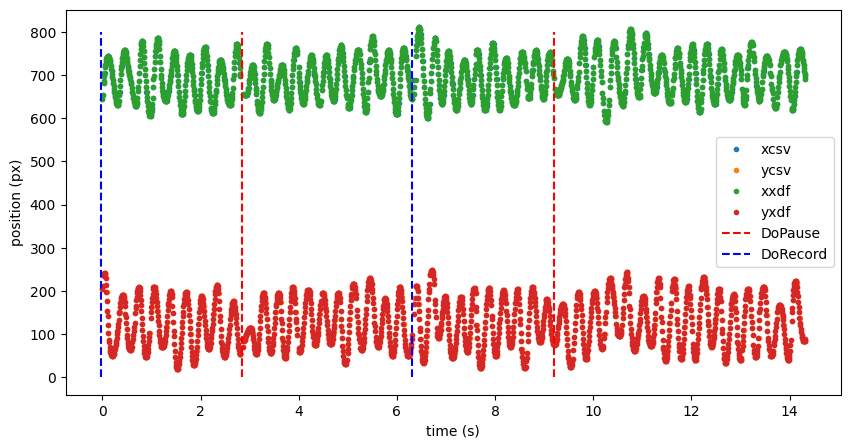

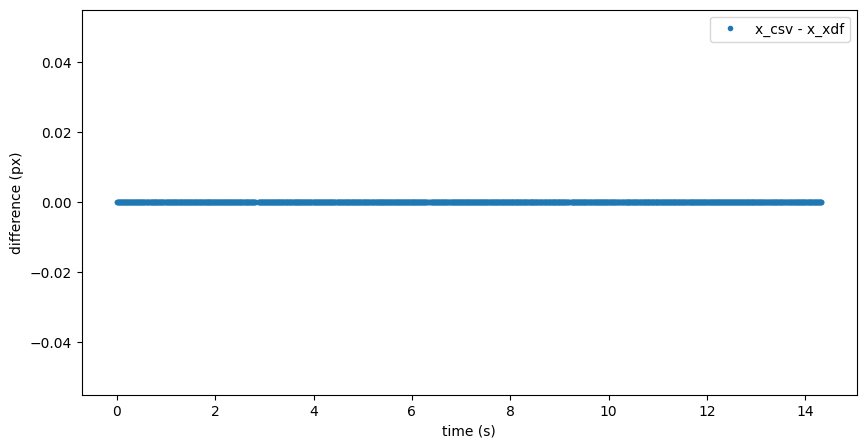

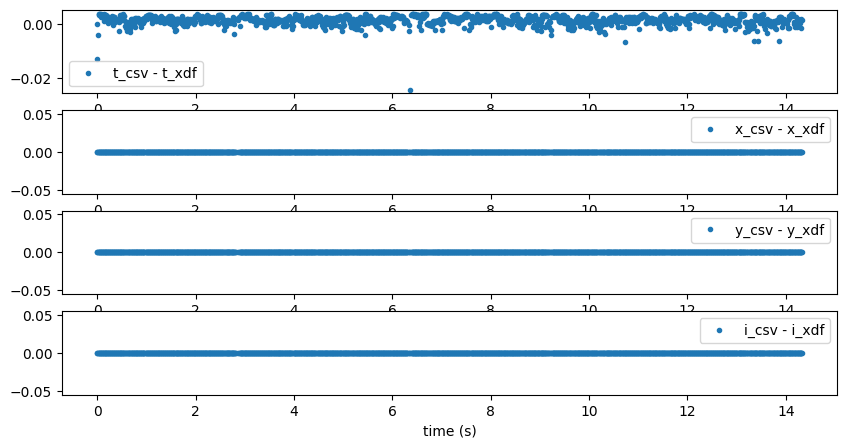

In [12]:
# load only the mouse data from the xdf file
mouse = pyxdf.load_xdf(fnameXDF, select_streams=[{'name': 'MouseData'}])[0][0]

# time in sec from start of recording
t_xdf = mouse['time_stamps'] - mouse['time_stamps'][0]
t_csv = data_csv[:,0]

# create a data array similar to the csv data
xyi_xdf = mouse['time_series']
data_xdf = np.column_stack((t_xdf, xyi_xdf))

def removeZerosXYI(data):
    # forget about time column
    data2search = data[:,1:3]
    # find rows full of zeros in x y i columns
    rows = np.where(~data2search.any(axis=1))[0]
    # replace rows full of zeros with NaN
    data[rows,:] = np.nan
    return data

data_xdf = removeZerosXYI(data_xdf)
data_csv = removeZerosXYI(data_csv) # already done before (normally)

# print the shape of csv and xdf data for comparison
print(f'CSV:{data_csv.shape}\nXDF:{data_xdf.shape}')

# the xdf data has one more row than the csv data
data_xdf = data_xdf[:-1]

def plotData(data, label):
    """Plot the data"""
    t = data[:,0]
    x = data[:,1]
    y = data[:,2]

    ax.plot(t, x, ".", label='x'+label)
    ax.plot(t, y, ".", label='y'+label)

# plot the xdf and csv data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plotData(data_csv, 'csv')
plotData(data_xdf, 'xdf')

plotMarker(ax, timeDoPause , 'DoPause', color='red')
plotMarker(ax, timeDoRecord, 'DoRecord', color='blue')

legend = ax.legend()
xlabel = ax.set_xlabel('time (s)')
ylabel = ax.set_ylabel('position (px)')

plt.show()

# plot the difference between the two data sets
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x_csv = data_csv[:,1]
x_xdf = data_xdf[:,1]

delta = x_csv - x_xdf
ax.plot(t_csv, delta, ".", label='x_csv - x_xdf')

legend = ax.legend()
xlabel = ax.set_xlabel('time (s)')
ylabel = ax.set_ylabel('difference (px)')

plt.show()


delta = data_csv - data_xdf

# plot the difference between the two data sets, one subplot for each column
fig, ax = plt.subplots(4, 1, figsize=(10, 5))

dt = delta[:,0]
dx = delta[:,1]
dy = delta[:,2]
di = delta[:,3]

ax[0].plot(t_csv, dt, ".", label='t_csv - t_xdf')

ax[1].plot(t_csv, dx, ".", label='x_csv - x_xdf')

ax[2].plot(t_csv, dy, ".", label='y_csv - y_xdf')

ax[3].plot(t_csv, di, ".", label='i_csv - i_xdf')

for i in range(4):
    legend = ax[i].legend()
    ax[i].set_xlabel('time (s)')

plt.show()